#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 5: Using Categorical Features

**Learning Objectives:**
* Use numerical and categorical features in TF to train a model

### Standard Set-up

We begin with the standard set-up, use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile) and replace missing numerical values by the column mean.

For this lab we are going to use categorical features in our model.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error. You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have one digit for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')


# Replace missing values by the column mean
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')
car_data.fillna(car_data.mean(), inplace=True)

# We'll then randomize the order of the rows.
car_data = car_data.reindex(np.random.permutation(car_data.index))

### Functions to help visualize our results


As in the past we define functions to generate a calibration plot and learning curve.

In [0]:
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])
  
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

### Setting Up the Feature Columns and Input Function for TensorFlow
As in the past labs, we define `input_fn` and `train_input_fn` to use the training data. The change here is that we now introduce some categorical columns.

In [0]:
NUMERICAL_COLUMNS = ["horsepower", "highway-mpg", "city-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_COLUMNS = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping from each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  """Sets up the input function using the training data.

  Returns:
     The feature columns to use for training and the associated labels.
  """
  return input_fn(training_examples)

### Functions for defining the linear regression model and training it

We use the same method as in the last lab to define the linear regression model and have simplified `train_model` to just show a calibration plot since usually we would use more than a single numerical feature to train a model.

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear regressor created with the given parameters.
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets.
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the loss, slope (feature weight), bias, and a name
  # for the model when there is a single feature (which then allows us
  # to plot the model in a scatter plot).
  print "Training model..."
  training_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps.
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions from the current model.
    predictions = np.array(list(linear_regressor.predict(
        input_fn=train_input_fn)))
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete and print the current loss
    loss = compute_loss(predictions, training_examples[LABEL])
    training_losses.append(loss) 
    print "  Loss after period %02d : %0.3f" % (period, loss)
      
  # Now that training is done, print the final loss.
  print "Final Loss (RMSE) on the training data: %0.3f" % loss 
  
  # Generate a figure with the learning curve on the left and a calibration
  # plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
 
  plt.title("Calibration Plot")
  make_calibration_plot(predictions, training_examples[LABEL])
   
  return linear_regressor

### Generate the Training Examples
Since the columns corresponding to the categorical features will be 0 or 1, we want to linearly scale the numerical features when generating the training examples.

In [0]:
NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

# Linearly rescales to the range [0, 1]
def linear_scale(column):
  min_val = column.min()
  max_val = column.max()
  # multiply scale by 1.0 so that it is used as a real value (vs integer)
  scale = 1.0 * (max_val - min_val)
  return column.apply(lambda x: (x - min_val) / scale)

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in NUMERICAL_FEATURES:
    if (feature != LABEL):
      processed_features[feature] = linear_scale(processed_features[feature])
  return processed_features

# Generate the training examples
training_examples = prepare_features(car_data)
training_examples[1:10]

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
152,1,74,toyota,gas,std,four,hatchback,fwd,front,95.70,...,92,2bbl,3.05,3.03,0.12,0.06,0.27,31,0.58,0.03
173,-1,65,toyota,gas,std,four,sedan,fwd,front,102.40,...,122,mpfi,3.31,3.54,0.11,0.18,0.02,29,0.47,0.10
130,0,?,renault,gas,std,four,wagon,fwd,front,96.10,...,132,mpfi,3.46,3.90,0.11,0.23,0.40,23,0.39,0.10
134,3,150,saab,gas,std,two,hatchback,fwd,front,99.10,...,121,mpfi,2.54,2.07,0.14,0.26,0.45,21,0.32,0.25
132,3,150,saab,gas,std,two,hatchback,fwd,front,99.10,...,121,mpfi,3.54,3.07,0.14,0.26,0.45,21,0.32,0.17
141,0,102,subaru,gas,std,four,sedan,fwd,front,97.20,...,108,2bbl,3.62,2.64,0.16,0.14,0.27,32,0.55,0.05
101,0,128,nissan,gas,std,four,sedan,fwd,front,100.40,...,181,mpfi,3.43,3.27,0.12,0.43,0.43,17,0.16,0.21
114,0,?,peugot,diesel,turbo,four,wagon,rwd,front,114.20,...,152,idi,3.70,3.52,0.88,0.20,0.00,25,0.24,0.30
172,2,134,toyota,gas,std,two,convertible,rwd,front,98.40,...,146,mpfi,3.62,3.50,0.14,0.28,0.27,24,0.37,0.31


### Defining the features

We now modify `construct_feature_columns` to use both categorical and numerical columns. To get you started we'll show an example of how to set up each of the kind of features you will be using.  Then you can add in additional features corresponding to the features that you'd like to use when training your model.

####Categorical Feauture Columns with known values.

When the values are known you can simply use code like below.  If you would view the weights index 0 will be the first key provided, index 1, the next key,.....

```
   drive_wheels = tf.contrib.layers.sparse_column_with_keys(
       column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
```

####Categorical Feature Columns without known values

Since you don't always know the possible values you can instead assign an index to each possible value via hashing.

```
   make = tf.contrib.layers.sparse_column_with_hash_bucket("make", hash_bucket_size=100)
```

####Numerical Columns directly used as a real number
As we have seen in the past lab, we can directly use a real-valued column as a feature
```
   price = tf.contrib.layers.real_valued_column("price") 
```


In [0]:
def construct_feature_columns():
  """Construct TensorFlow feature columns.
  
  Returns:
    A set of feature columns.
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  return [drive_wheels, make, price]

### Train a model

Training model...
  Loss after period 00 : 4.285
  Loss after period 01 : 4.007
  Loss after period 02 : 3.912
  Loss after period 03 : 3.867
  Loss after period 04 : 3.840
  Loss after period 05 : 3.822
  Loss after period 06 : 3.809
  Loss after period 07 : 3.800
  Loss after period 08 : 3.793
  Loss after period 09 : 3.788
Final Loss (RMSE) on the training data: 3.788


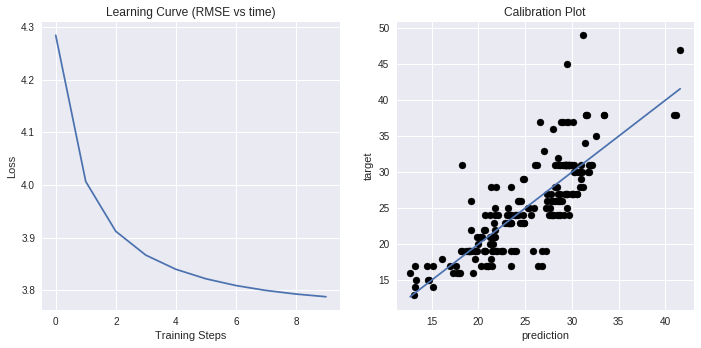

In [0]:
LEARNING_RATE = 0.25
STEPS = 750

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

###Look at the weights###

In [0]:
# Illustrating how to see all the weights in the model
print linear_regressor.get_variable_names()

for feature in ["price"]:
  if feature != LABEL:
    w = linear_regressor.get_variable_value('linear/' + feature + '/weight')[0]
    print "weight for", feature, "is", w
for feature in ["make", "drive-wheels"]:
  w = linear_regressor.get_variable_value('linear/' + feature + '/weights')
  print "more significant weights for", feature, "are:"
  for weight, i in zip(w, range(len(w))):
    if (weight > 1 or weight < -1):
        print "   index", i, "of weight", weight  
print "bias:",  linear_regressor.get_variable_value("linear/bias_weight")

['global_step', 'linear/bias_weight', 'linear/drive-wheels/weights', 'linear/make/weights', 'linear/price/weight']
weight for price is [-17.399109]
more significant weights for make are:
   index 20 of weight [-5.2063003]
   index 22 of weight [-1.2698869]
   index 25 of weight [-1.1195344]
   index 30 of weight [11.079631]
   index 32 of weight [2.3963656]
   index 37 of weight [2.9152598]
   index 50 of weight [2.878638]
   index 51 of weight [2.1133192]
   index 53 of weight [-5.414557]
   index 57 of weight [6.362201]
   index 61 of weight [4.284948]
   index 72 of weight [1.2287275]
   index 76 of weight [6.586818]
   index 77 of weight [-5.832382]
   index 82 of weight [-3.783263]
   index 91 of weight [2.6997168]
more significant weights for drive-wheels are:
   index 0 of weight [10.17119]
   index 1 of weight [3.712542]
   index 2 of weight [6.4599032]
bias: [20.34361]


Recall that the keys for `drive-wheels` are `keys=["fwd", "rwd", "4wd"])`.  If you want to be able to correlate the makes with the keys then you'd wnat to use `sparse_column_with_keys`.

## Task 1 (5 points)

Train the best model you can to predict `city-mpg` using any features with whatever feature processing you'd like to include. Make use of all that you've done in the previous labs. The codebox below gives you an example.  Right now it just trains the same model as above.  You should modify `construct_feature_columns` to include the features you'd like to use, and of course modify the learning rate and number of steps to train the model. You can duplicate this code box in order to show the results for more than one model. Please submit the lab with the model you trained that had the lowest loss and also one or two others that you feel are interesting.

Training model...
  Loss after period 00 : 2.753
  Loss after period 01 : 2.736
  Loss after period 02 : 2.735
  Loss after period 03 : 2.734
  Loss after period 04 : 2.734
  Loss after period 05 : 2.734
  Loss after period 06 : 2.734
  Loss after period 07 : 2.734
  Loss after period 08 : 2.734
  Loss after period 09 : 2.734
Final Loss (RMSE) on the training data: 2.734


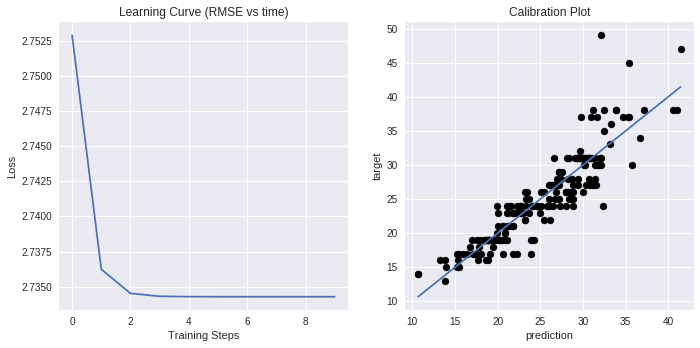

In [0]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  fuel_system = tf.contrib.layers.sparse_column_with_keys(
      column_name="fuel-system", keys=["1bbl", "2bbl", "4bbl", "idi", "mfi", "mpfi", "spdi", "spfi"])
  fuel_type = tf.contrib.layers.sparse_column_with_keys(
      column_name="fuel-type", keys=["diesel", "gas"])
  body_style = tf.contrib.layers.sparse_column_with_keys(
      column_name="body-style", keys=["hardtop", "wagon", "sedan", "hatchback", "convertible"])
  
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  return [drive_wheels,fuel_system, fuel_type, body_style, make, price]

LEARNING_RATE = 0.15
STEPS = 10000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)